In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [12]:
import os

num_skipped = 0
for folder_name in ("baseball", "basketball", "boxing"):
    folder_path = os.path.join("data_1", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [13]:
image_size = (500, 500)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data_1",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data_1",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1815 files belonging to 3 classes.
Using 1452 files for training.
Found 1815 files belonging to 3 classes.
Using 363 files for validation.


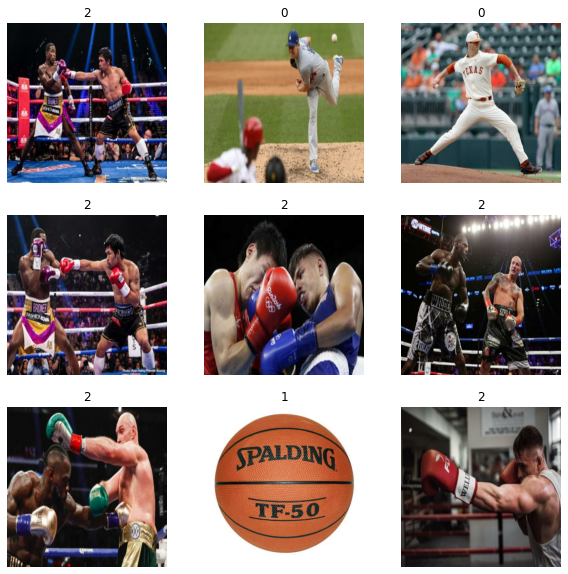

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [15]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),])

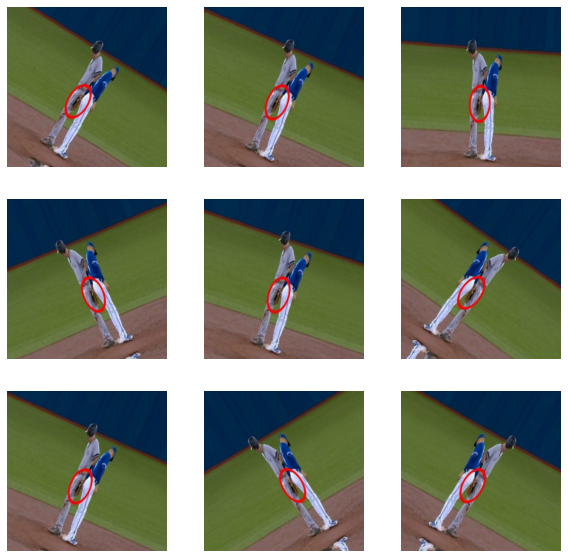

In [16]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [17]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [18]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

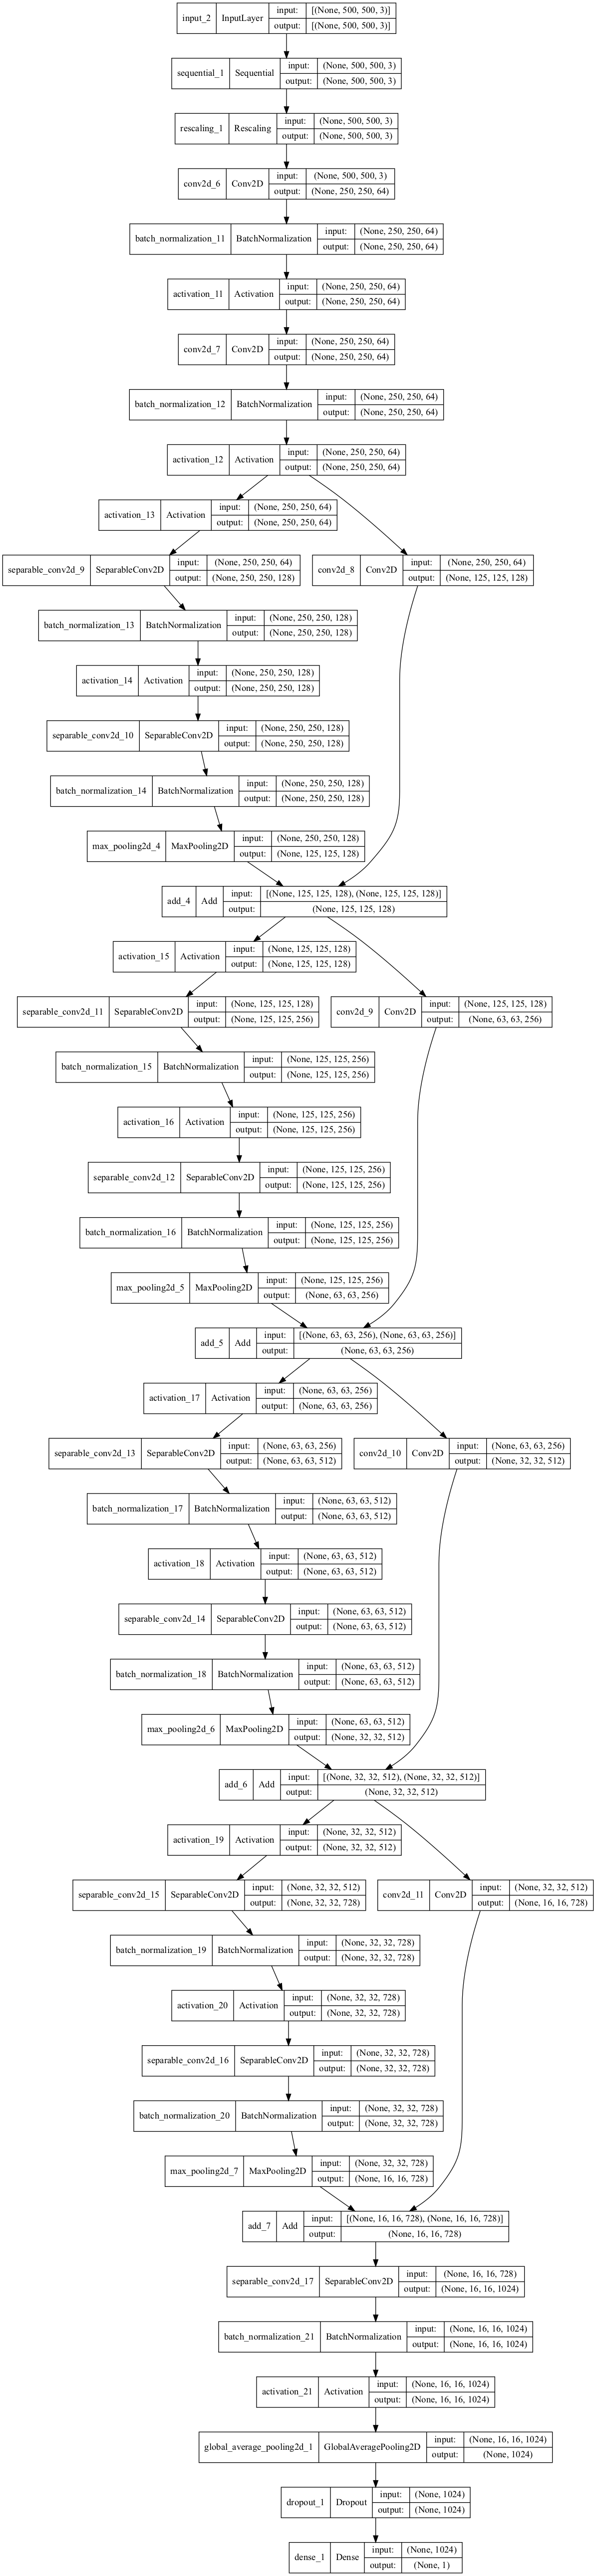

In [19]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [20]:
epochs = 1

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5")]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"])

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds)

 3/46 [>.............................] - ETA: 17:32 - loss: -0.1022 - accuracy: 0.4375

KeyboardInterrupt: 

In [21]:
img = keras.preprocessing.image.load_img(
    "data_1/baseball/00000008.JPG", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "There is a %.2f percent that this is a baseball scene."
    % (100 * (1 - score))
)

There is a 49.56 percent that this is a baseball scene.


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential 
from keras.layers import Activation, Dense 
from keras import initializers 

my_init1 = initializers.TruncatedNormal(mean = 0.0, stddev = 0.05, seed = None)

In [24]:
img_width = 500
img_height = 500

In [28]:
model_1 = Sequential()
model_1.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
model_1.add(MaxPooling2D(pool_size = (2, 2)))
model_1.add(Flatten())
model_1.add(Dense(activation = 'relu', units = 128))#, kernel_initializer = my_init))
model_1.add(Dense(activation = 'relu', units = 64, kernel_initializer = my_init1))
model_1.add(Dense(activation = 'relu', units = 32))
model_1.add(Dense(activation = 'sigmoid', units = 1))
model_1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [29]:
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 498, 498, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 249, 249, 32)     0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1984032)           0         
                                                                 
 dense_6 (Dense)             (None, 128)               253956224 
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                      

In [30]:
epochs = 1

model_1.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds)

46/46 [==============================] - 96s 2s/step - loss: -18784.0723 - accuracy: 0.3251 - val_loss: -75344.7969 - val_accuracy: 0.2755


In [31]:
test_a = model.evaluate(val_ds)
print('The testing accuracy is :',test_a[1]*100, '%')

12/12 [==============================] - 45s 4s/step - loss: 0.6718 - accuracy: 0.2424
The testing accuracy is : 24.242424964904785 %


In [32]:
img = keras.preprocessing.image.load_img(
    "data_1/basketball/00000012.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "There is a %.2f percent chance this picture has to do with Basketball."
    % (100 * (1 - score)))

There is a 49.25 percent chance this picture has to do with Basketball.
